# CTA Ridership Insights: What was COVID-19's effect on the 'L', and has its ridership recovered?
The CTA is an integral part of life in Chicago, and Chicagoans enjoy one of the best transit systems in the country (see transit ranking data here: https://alltransit.cnt.org/rankings/).

However, CoVID19 has taken a toll on many aspects of life. As an L customer, myself, I've noticed some reductions in service in the years following the start of the pandemic. Funding for public transit often depends on how many people regularly buy tickets, so my goal with this project is to assess the effect of CoVID on Chicago's CTA ridership. I will
1. Import the CTA's 'L' ridership data using the City of Chicago's API.
2. Clean the data by removing stations with large amounts of missing data and removing 0 values
3. Explore and visualize the dataset
4. Track ridership before and after CoVID, checking for different effects across stations with different levels of ridership. Note: I will say pre/post-COVID as a way to distinguish the time periods I'm interested in. I mean pre/post- the timepoint when the World Health Organization declared a global pandemic.
5. Make a prediction about when/if ridership will return to pre-pandemic levels.

Next steps:
Ridership still hasn't recovered. To check whether the decreased ridership is linked to an increase in car traffic congestion, look at this dataset: https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Se/n4j6-wkkf

## 1.) Import CTA ridership data
To download current ridership data, I am using the API that the City of Chicago uses, Socrata. This API is free to use, and you can sign up for app tokens and API keys, or learn more about it here: https://dev.socrata.com/foundry/data.cityofchicago.org/6iiy-9s97

To hide my credentials and keep the dataset consistent, I will use the .csv that I downloaded previously, but will include the skeleton of the API request for reference.

In [1]:
import pandas as pd
from sodapy import Socrata # this is the API that Chicago CTA uses

# Read the .csv I dowloaded from the city of Chicago
ridership_df = pd.read_csv('LRidership.csv')

### Can use Chicago's API for dashboarding purposes (credentials hidden)
# client = Socrata("data.cityofchicago.org",
#                 MyAppToken,
#                 username=MyUsername,
#                 password=MyPassword,
#                 timeout=30)
#ridership_df = client.get("5neh-572f", limit=10000000, content_type='csv')

#Convert the list we received from the API to a dataframe
#ridership_df = pd.DataFrame(ridership_df[1:], columns=ridership_df[0])

# specify the format of each column
ridership_df['station_id'] = ridership_df['station_id'].astype('int64')
ridership_df['rides'] = ridership_df['rides'].astype('int64')
ridership_df['stationname'] = ridership_df['stationname'].astype('str')
ridership_df['daytype'] = ridership_df['daytype'].astype('str')
ridership_df['date'] = pd.to_datetime(ridership_df['date'], format='%Y-%m-%dT%H:%M:%S.%f')
og_size = ridership_df.shape[0]
og_stations = ridership_df['stationname'].unique()
ridership_df.head()

### Alternatively, you could use the API's endpoint to directly download data, but its throttled at only 1000 entries
#df = pandas.read_csv('https://data.cityofchicago.org/resource/5neh-572f.csv')

### For more information on this datset, go here:
#https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f




,Unnamed: 0,station_id,stationname,date,daytype,rides
0,0,40350,UIC-Halsted,2001-01-01,U,273
1,1,41130,Halsted-Orange,2001-01-01,U,306
2,2,40760,Granville,2001-01-01,U,1059
3,3,40070,Jackson/Dearborn,2001-01-01,U,649
4,4,40090,Damen-Brown,2001-01-01,U,411


## 2. Clean the Dataset
#### Initial data cleaning
As an initial quality check, I look at the number of data entries for each station, as well as 0 or Null values. This dataset doesn't contain any Null values, but it does have instances where 0's are logged, either for computer error or because the stations are not functioning at that time. 

After plotting total ridership since 2001, we can see that the data is distributed most densely around 20,000,000 total rides, though there is a clear outlier- The Homan station only has 27 rides. This station was demolished in 2000, so I am dropping it from our data. Upon closer inspection, there are some stations that have fewer entries than others, or include 0 values for rides. Some stations, like Homan, have entries for rides that are under 30. I am treating cases like these as 0 values, as they're likely to be errors.

1. Check for stations with poor quality data (many missing values or 0's)
2. Drop entries with under 30 rides
3. Drop stations that have less than 60% of the median number of entries

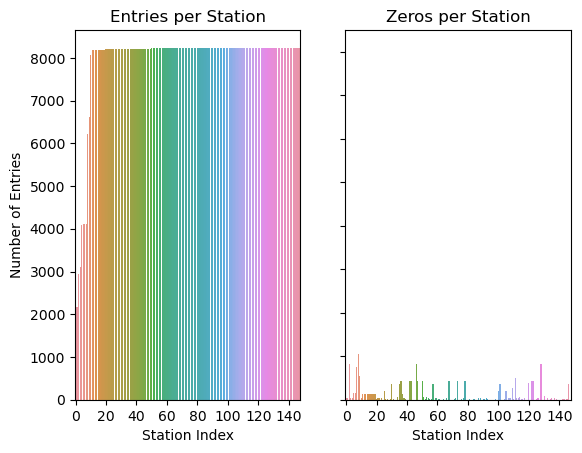

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

## Check to see how many stations are missing entries or contain 0's

# find which stations have the most 0 value entries
total_zeros = pd.DataFrame(ridership_df[ridership_df['rides'] <= 30].groupby('stationname').count()['rides']).reset_index()
total_zeros.columns=['stationname', 'zeros']

total_entries = pd.DataFrame(ridership_df[['stationname', 'rides']].groupby('stationname').count()['rides']).reset_index()
total_entries.columns=['stationname', 'entries']

# Merge based on the 'id' column
missing_data_df = pd.merge(total_entries, total_zeros, on='stationname', how='outer').sort_values(by='entries')
old_station_num = missing_data_df.shape[0] + 1

# Plot the # of entries to check if stations are missing significant amounts of data
left = plt.subplot(1, 2, 1)
sns.barplot(ax=left, data=missing_data_df, x=list(range(1, old_station_num)), y='entries') 

# Set x-axis ticks and label every 20 labels
xtick_positions = list(range(0, old_station_num, 20))
xtick_labels = list(range(0, old_station_num, 20))
plt.xticks(xtick_positions, xtick_labels)
plt.xlabel('Station Index')
plt.ylabel('Number of Entries')
plt.title('Entries per Station')

# Plot the # of 0's to check if stations are missing significant amounts of data
right = plt.subplot(1, 2, 2)
sns.barplot(ax=right, data=missing_data_df, x=list(range(1, old_station_num)), y='zeros')

## Set x-axis ticks and label every 20 labels
xtick_positions = list(range(0, old_station_num, 20))
xtick_labels = list(range(0, old_station_num, 20))
plt.xticks(xtick_positions, xtick_labels)
plt.xlabel('Station Index')
plt.ylabel('Number of Entries')
plt.title('Zeros per Station')
plt.ylabel('')

# Remove y-axis tick labels
right.set_yticklabels([])  # Set tick labels to empty strings
plt.ylim([0, 8500])
plt.show()

Dropped 16594 rows of raw data
Dropped 8 stations for too few entries
['Skokie', 'Washington/State', 'Homan', 'Dempster-Skokie', 'Oakton-Skokie', 'Morgan-Lake', 'Cermak-McCormick Place', 'Washington/Wabash']


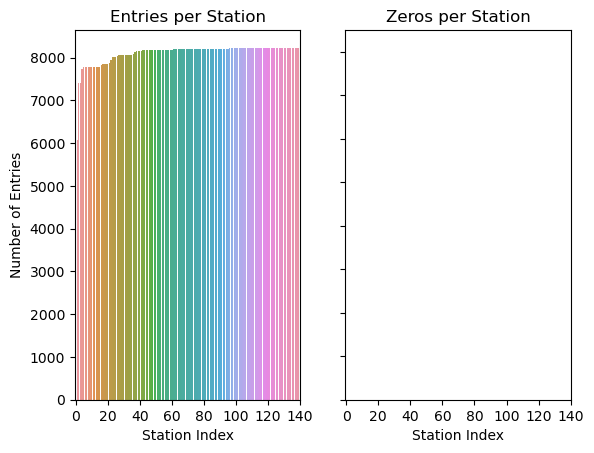

In [3]:
# Remove rows with too few ride entries, and delete entries with 0 values
ridership_df = ridership_df[ridership_df['rides'] > 30]
new_size = ridership_df.shape[0]

# find which stations have the entrees and the most 0's
total_zeros = pd.DataFrame(ridership_df[ridership_df['rides'] <= 30].groupby('stationname').count()['rides']).reset_index()
total_zeros.columns=['stationname', 'zeros']
total_entries = pd.DataFrame(ridership_df[['stationname', 'rides']].groupby('stationname').count()['rides']).reset_index()
total_entries.columns=['stationname', 'entries']

# Merge based on the 'stationname' column
missing_data_df = pd.merge(total_entries, total_zeros, on='stationname', how='outer').sort_values(by='entries')

# Remove stations with less than 75% of the median # of entries
med_threshold = 0.60*missing_data_df['entries'].median()
missing_data_df = missing_data_df[missing_data_df['entries'] > med_threshold]
new_stations = missing_data_df['stationname'].unique()
new_station_num = 1 + missing_data_df.shape[0]
print('Dropped', og_size - new_size, 'rows of raw data')
print('Dropped', old_station_num - new_station_num, 'stations for too few entries')
dropped_stations = [station for station in og_stations if station not in new_stations]
print(dropped_stations)

# Plot the # of entries to check if stations are missing significant amounts of data
left = plt.subplot(1, 2, 1)
sns.barplot(ax=left, data=missing_data_df, x=list(range(1, new_station_num)), y='entries')

# Set x-axis ticks and label every 20 labels
xtick_positions = list(range(0, new_station_num, 20))
xtick_labels = list(range(0, new_station_num, 20))
plt.xticks(xtick_positions, xtick_labels)
plt.xlabel('Station Index')
plt.ylabel('Number of Entries')
plt.title('Entries per Station')

# Plot the # of 0's to check if stations are missing significant amounts of data
right = plt.subplot(1, 2, 2)
sns.barplot(ax=right, data=missing_data_df, x=list(range(1, new_station_num)), y='zeros')
## Set x-axis ticks and label every 20 labels
xtick_positions = list(range(0, new_station_num, 20))
xtick_labels = list(range(0, new_station_num, 20))
plt.xticks(xtick_positions, xtick_labels)
plt.xlabel('Station Index')
plt.ylabel('Number of Entries')
plt.title('Zeros per Station')
plt.ylabel('')

# Remove y-axis tick labels
right.set_yticklabels([])  # Set tick labels to empty strings
plt.ylim([0, 8500])
plt.show()


# 3. Explore and Visualize
I've now dealt with the 0's and removed stations with too little data. Next, I want to visualize the data. First, I used plotly to take a look at some individual stations to get a feel for what happened when the pandemic hit. You can use the dropdown menu to scroll through any station. Notice the dramatic hit in rides that most stations take in 2020.


In [4]:
import pandas as pd
import plotly.express as px
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go

# Define the function to plot station rides
def plot_station_rides(station_name, clear):
    if clear == 1:
        clear_output(wait=True)
    # Filter the DataFrame based on the selected station_name
    filtered_df = ridership_df[ridership_df['stationname'] == station_name]
    week_rides = filtered_df[filtered_df['daytype'] == 'W']
    sat_rides = filtered_df[filtered_df['daytype'] == 'A']
    sun_rides = filtered_df[filtered_df['daytype'] == 'U']
    # Create a line plot using Plotly
    fig = go.Figure()
    #fig.add_trace(go.Scatter(x=filtered_df['date'], y=filtered_df['rides'], mode='lines+markers'))
    fig.add_trace(go.Scatter(x=week_rides['date'], y=week_rides['rides'], mode='lines', name='Weekdays', line=dict(shape='spline', smoothing=1), legendgroup='rides'))
    fig.add_trace(go.Scatter(x=sat_rides['date'], y=sat_rides['rides'], mode='lines', name='Saturdays', line=dict(shape='spline', smoothing=1), legendgroup='rides'))
    fig.add_trace(go.Scatter(x=sun_rides['date'], y=sun_rides['rides'], mode='lines', name='Sundays', line=dict(shape='spline', smoothing=1), legendgroup='rides'))
    
    # Access the maximum y-value (upper limit) from the graph
    max_y_value = max([max(trace.y) for trace in fig.data])
    
    # Add a shape to indicate when the WHO declared a pandemic
    fig.add_shape(
        go.layout.Shape(
            type='line',
            x0='2020-03-11',
            x1='2020-03-11',
            y0=0,
            y1=max_y_value,  # Adjust the y1 value as needed
            line=dict(color='purple', width=2),
            name='COVID19 Declared Pandemic',
        )
        
    )
    
    # Create a dummy scatter trace to represent the shape in the legend
    fig.add_trace(go.Scatter(x=['2020-03-11'], y=[max_y_value], mode='lines', name='COVID19 Declared Pandemic', line=dict(color='purple', width=2)))


    fig.update_layout(
        title=f'Total rides for Station {station_name}',
        xaxis_title='Date',
        yaxis_title='Number of Rides'
    )
    
    fig.show()

# Create an interactive widget to select the station_name parameter
station_selector = widgets.Dropdown(
    options=ridership_df['stationname'].unique(),
    description='Select Station:',
    disabled=False,
    value=ridership_df['stationname'].iloc[-1]
)

# Define a function to update the plot when the station is selected
def on_station_change(change):
    station_name = change.new
    plot_station_rides(station_name, 1)
    display(station_selector)

# Attach the function to the widget's value change event
station_selector.observe(on_station_change, names='value')

# Display the initial plot with the first station
fig = plot_station_rides(ridership_df['stationname'].iloc[-1], 0)

# Display the widget
display(station_selector)


Dropdown(description='Select Station:', index=146, options=('UIC-Halsted', 'Halsted-Orange', 'Granville', 'Jac…

# 4. Track ridership before and after COVID
The pandemic has had a major effect on how many people are taking trains within Chicago. There are probably many factors contributing to this. I will look at the popularity of stations, as well as the differences between weekdays and weekends to see if there are any differences in ridership recovery based on these factors.
#### Divide the stations based on ridership level to check if there are differences in recovery trends

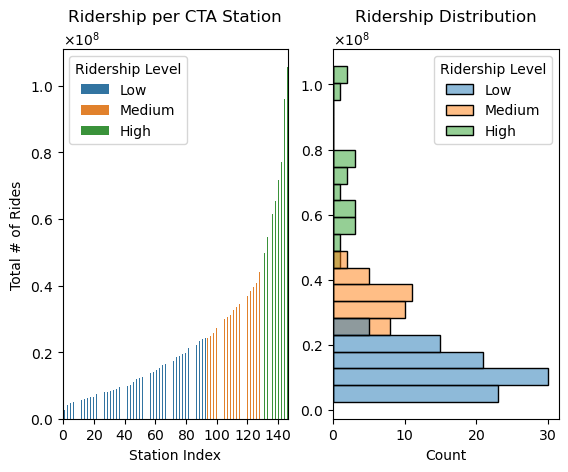

Low traffic stations contain 0.32666501531730446 percent of rides, with 94 Stations included
Medium traffic stations contain 0.3367376014189585 percent of rides 36 Stations included
High traffic stations contain 0.33659738326373706 percent of rides 17 Stations included


In [5]:
import matplotlib.ticker as ticker
import numpy as np

# Check the distribution of ridership of all the stations, since 2001
all_time_ridership = ridership_df[['stationname', 'rides']].groupby('stationname').agg('sum').sort_values(by=['rides'])
all_time_ridership.reset_index(inplace=True)

# Choose how to segment low, medium, and high traffic stations with grouping variable
# 1 = thresholds based on the number of stations (each group has same # of stations) 
# 2 = thresholds by number of rides (each group has same % of rides)
grouping = 2

if grouping == 1:
    # Segment stations into low, medium, and high ridership. Simply segment into thirds based on number of stations
    station_num = all_time_ridership.shape[0]
    bucket_size = int(station_num/3)
    ridership_labels = bucket_size*['Low'] + bucket_size*['Medium'] + bucket_size*['High']
    all_time_ridership['Ridership Level'] = ridership_labels
elif grouping == 2:
    # Alternate binning method- sort into groups that each contain 1/3 of all rides
    # Calculate the cumulative sum
    cumulative_sum = np.cumsum(all_time_ridership.rides)

    # Calculate the cumulative relative frequency
    cumulative_relative_frequency = cumulative_sum / np.sum(all_time_ridership.rides)

    # Define bin edges to split the data into roughly equal thirds
    bin_edges = [0.0, 0.33, 0.67, 1.01]

    # Use the bin edges to split the data into three bins
    binned_data = np.digitize(cumulative_relative_frequency, bin_edges)
    all_time_ridership['Ridership Level'] = binned_data
    # Replace those 1, 2, 3 bin labels with low, medium, and high labels
    replace_dict = {1: 'Low',
                    2: 'Medium',
                    3: 'High'}
    all_time_ridership['Ridership Level'].replace(replace_dict, inplace=True)

# Define the figure size
left = plt.subplot(1, 2, 1)

# Plot the sum of all rides at all stations, sorted to get an idea of the data
sns.barplot(ax=left, data=all_time_ridership, x=list(range(1, 148)), y='rides', hue='Ridership Level')

# Position the legend in the top-left corner
plt.legend(loc='upper left', title='Ridership Level')

# Set x-axis ticks and label every 20 labels
xtick_positions = list(range(0, 148, 20))
xtick_labels = list(range(0, 148, 20))
plt.xticks(xtick_positions, xtick_labels)
plt.title('Ridership per CTA Station')
# Turn off the legend
plt.ylabel('Total # of Rides')
plt.xlabel('Station Index')

# Configure the format of tick labels on the x and y axes
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))  # Adjust power limits as needed
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Plot a histogram of the data to look at the distribution
right = plt.subplot(1, 2, 2)
sns.histplot(ax=right, data=all_time_ridership, y='rides', hue='Ridership Level', bins=20)
# Configure the format of tick labels on the x and y axes
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))  # Adjust power limits as needed
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('')
plt.title('Ridership Distribution')
plt.show()  # Show the plot

low_total = all_time_ridership[all_time_ridership['Ridership Level'] == 'Low'].rides.sum()
med_total = all_time_ridership[all_time_ridership['Ridership Level'] == 'Medium'].rides.sum()
high_total = all_time_ridership[all_time_ridership['Ridership Level'] == 'High'].rides.sum()

# Now work with the groups- segment the data by level of ridership to look at averages over time
low_ride_stations = all_time_ridership[all_time_ridership['Ridership Level'] == 'Low'][['stationname']]
med_ride_stations = all_time_ridership[all_time_ridership['Ridership Level'] == 'Medium'][['stationname']]
high_ride_stations = all_time_ridership[all_time_ridership['Ridership Level'] == 'High'][['stationname']]

station_groups = all_time_ridership.groupby('Ridership Level')['stationname'].count()

print('Low traffic stations contain', low_total/all_time_ridership.rides.sum(), 'percent of rides, with', station_groups['Low'], 'Stations included')
print('Medium traffic stations contain', med_total/all_time_ridership.rides.sum(), 'percent of rides', station_groups['Medium'], 'Stations included')
print('High traffic stations contain', high_total/all_time_ridership.rides.sum(), 'percent of rides', station_groups['High'], 'Stations included')

#### Examine Individual Station Data
We can see from these groupings that there are some stations with a much higher percentage of total ridership, and some stations that have comparatively fewer rides. Next, I will plot the monthly median rides from each category to show the effect of the pandemic.

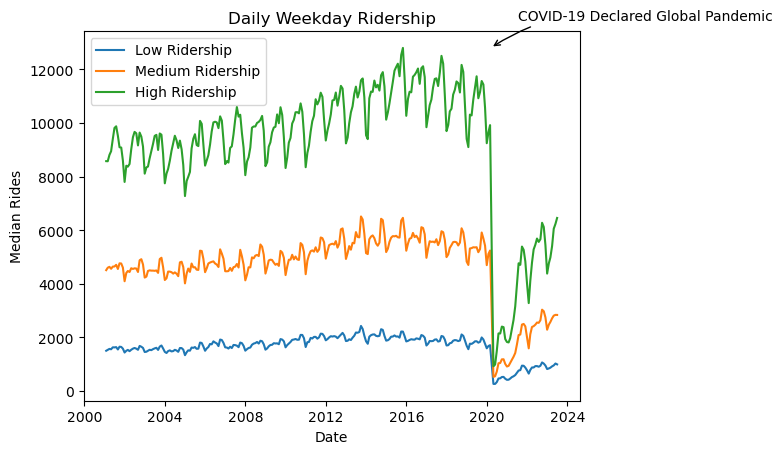

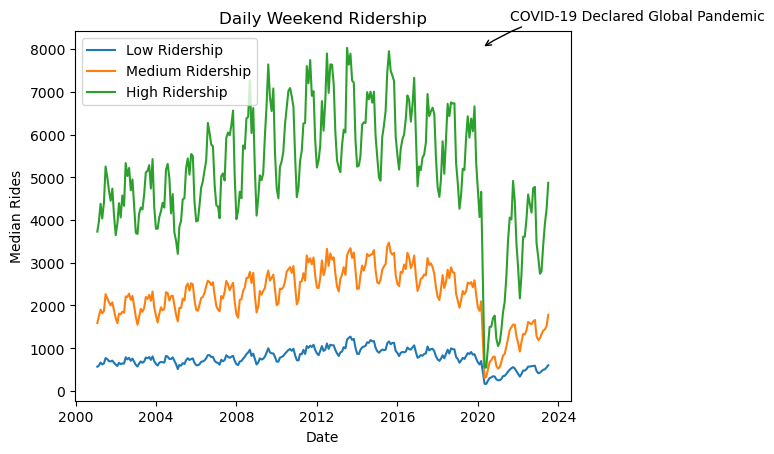

In [6]:
from datetime import datetime
def plot_by_ridership(low_ride_stations, med_ride_stations, high_ride_stations, ridership_df, daytype):
    """Plot the daily number of rides of low, medium, and high traffic stations, given dataframes containing low, medium, and high traffic stations, ridership_df containing all L ride data, and daytype, a list containing codes of day types ('U', 'W', or 'A')"""
    
    # Get the median rides per day for each ridership group

    # Get data for all low ridership stations
    low_ridership_df = ridership_df[ridership_df['stationname'].isin(low_ride_stations['stationname'])]

    # Of that data, select only the weekday rides
    low_rider_week_df = low_ridership_df[low_ridership_df['daytype'].isin(daytype)]

    # Get group the low ridership stations' ride data by date, selecting the median value for each date, then resampling by choosing the average point from each month
    low_result = low_rider_week_df.groupby('date')['rides'].agg(Median='median').resample('M').mean()

    med_ridership_df = ridership_df[ridership_df['stationname'].isin(med_ride_stations['stationname'])]
    med_rider_week_df = med_ridership_df[med_ridership_df['daytype'].isin(daytype)]
    med_result = med_rider_week_df.groupby('date')['rides'].agg(Median='median').resample('M').mean()

    high_ridership_df = ridership_df[ridership_df['stationname'].isin(high_ride_stations['stationname'])]
    high_rider_week_df = high_ridership_df[high_ridership_df['daytype'].isin(daytype)]
    high_result = high_rider_week_df.groupby('date')['rides'].agg(Median='median').resample('M').mean()

    #fig = plt.figure(figsize=(12,6))
    sns.lineplot(data=low_result, x='date', y='Median', label='Low Ridership')
    sns.lineplot(data=med_result, x='date', y='Median', label='Medium Ridership')
    sns.lineplot(data=high_result, x='date', y='Median', label='High Ridership')

    # Add an arrow to label pandemic WHO declaration
    covid_time = pd.to_datetime('2020-03-11T00:00:00.000', format='%Y-%m-%dT%H:%M:%S.%f') 
    arrow_text = 'COVID-19 Declared Global Pandemic'

    plt.annotate(arrow_text, (covid_time, high_result['Median'].max()),  # Adjust the position as needed
                xytext=(20, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# Plot the weekday rides
plot_by_ridership(low_ride_stations, med_ride_stations, high_ride_stations, ridership_df, ['W'])

# Add legend
plt.legend()
plt.title('Daily Weekday Ridership')
plt.ylabel('Median Rides')
plt.xlabel('Date')
# Show the plot
plt.show()

# Plot the weekend/holiday rides
plot_by_ridership(low_ride_stations, med_ride_stations, high_ride_stations, ridership_df, ['U', 'A'])

# Add legend
plt.legend()
plt.title('Daily Weekend Ridership')
plt.ylabel('Median Rides')
plt.xlabel('Date')
# Show the plot
plt.show()

#### Interpretting the data: 
Visually, it's clear ridership has not fully recovered to pre-pandemic levels (especially on weekdays), and this looks to be true across all stations, regardless of ridership levels. This could be for many reasons- people could opt to drive instead of take the trains, the number of people working remotely (and so not commuting as often on weekdays) likely increased, and people could be choosing not to go out quite as much. Additionally, it looks like weekday and weekend ridership may be affected differently by Covid. Next, I will look more closely at average ridership to visualize these differences.

Low Ridership stations have a 47.8 percent decrease in weekday rides, and a 35.3 percent decrease in weekend rides.
Medium Ridership stations have a 50.7 percent decrease in weekday rides, and a 38.5 percent decrease in weekend rides.
High Ridership stations have a 52.7 percent decrease in weekday rides, and a 35.8 percent decrease in weekend rides.


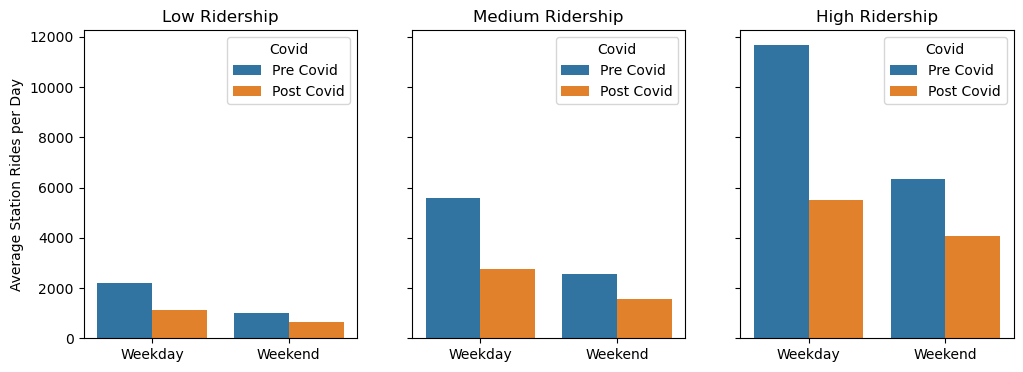

In [7]:
# Plot averages to get a clearer picture
from scipy import stats
import locale

# Set the locale to the user's default (usually based on system settings)
locale.setlocale(locale.LC_ALL, '')

# For analysis, find the time period of the newest data point - 1 year to be our year of "post-covid" data, and the same month/days from 2018-2019 to be our post-covid data
covid_time = pd.to_datetime('2020-03-11T00:00:00.000', format='%Y-%m-%dT%H:%M:%S.%f') 
post_end = ridership_df['date'].max()
post_start = post_end - pd.DateOffset(years=1)
offset = post_end.year - 2019
pre_start = post_start - pd.DateOffset(years=offset)
pre_end = post_end - pd.DateOffset(years=offset)

# Calculate average daily rides within a 1 year time period pre and post covid to guage ridership recovery
post_daily_weekdays_all_stations = ridership_df[(ridership_df['date'] > post_start) & (ridership_df['daytype'] == 'W')]
post_daily_weekends_all_stations = ridership_df[(ridership_df['date'] > post_start) & (ridership_df['daytype'].isin(['A', 'U']))]

pre_daily_weekdays_all_stations = ridership_df[(ridership_df['date'] > pre_start) & (ridership_df['date'] < pre_end) & (ridership_df['daytype'] == 'W')]
pre_daily_weekends_all_stations = ridership_df[(ridership_df['date'] > pre_start) & (ridership_df['date'] < pre_end) & (ridership_df['daytype'].isin(['A', 'U']))]

# create a new dataframe with the averages of all weekday or weekend rides. 

pre_week_ride_avgs = pd.DataFrame(pre_daily_weekdays_all_stations.groupby(['stationname', 'daytype'])['rides'].mean(numeric_only=True).reset_index())
pre_week_ride_avgs['DayType'] = pre_week_ride_avgs.shape[0]*['Weekday']
pre_week_ride_avgs['Covid'] = pre_week_ride_avgs.shape[0]*['Pre Covid']

post_week_ride_avgs = pd.DataFrame(post_daily_weekdays_all_stations.groupby(['stationname', 'daytype'])['rides'].mean(numeric_only=True).reset_index())
post_week_ride_avgs['DayType'] = post_week_ride_avgs.shape[0]*['Weekday']
post_week_ride_avgs['Covid'] = post_week_ride_avgs.shape[0]*['Post Covid']

pre_weekend_ride_avgs = pd.DataFrame(pre_daily_weekends_all_stations.groupby(['stationname', 'daytype'])['rides'].mean(numeric_only=True).reset_index())
pre_weekend_ride_avgs['DayType'] = pre_weekend_ride_avgs.shape[0]*['Weekend']
pre_weekend_ride_avgs['Covid'] = pre_weekend_ride_avgs.shape[0]*['Pre Covid']

post_weekend_ride_avgs = pd.DataFrame(post_daily_weekends_all_stations.groupby(['stationname', 'daytype'])['rides'].mean(numeric_only=True).reset_index())
post_weekend_ride_avgs['DayType'] = post_weekend_ride_avgs.shape[0]*['Weekend']
post_weekend_ride_avgs['Covid'] = post_weekend_ride_avgs.shape[0]*['Post Covid']

## Concatenate the DataFrames, replace daytype with Day Type (combines saturday and sundays into one category, 'Weekends', including holidays as well)
combined_ride_avgs_df = pd.concat([pre_week_ride_avgs, post_week_ride_avgs, pre_weekend_ride_avgs, post_weekend_ride_avgs])#
combined_ride_avgs_df = combined_ride_avgs_df.groupby(['stationname', 'DayType', 'Covid']).mean(numeric_only=True).reset_index()

## Plot all classes of station pre and post covid
low_riders_avgs = combined_ride_avgs_df[combined_ride_avgs_df['stationname'].isin(low_ride_stations.stationname)].groupby(['DayType', 'Covid']).mean(numeric_only=True).reset_index()
med_riders_avgs = combined_ride_avgs_df[combined_ride_avgs_df['stationname'].isin(med_ride_stations.stationname)].groupby(['DayType', 'Covid']).mean(numeric_only=True).reset_index()
high_riders_avgs = combined_ride_avgs_df[combined_ride_avgs_df['stationname'].isin(high_ride_stations.stationname)].groupby(['DayType', 'Covid']).mean(numeric_only=True).reset_index()

# Create a figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Loop through subplots and plot barplots
for i, (data, title) in enumerate(zip([low_riders_avgs, med_riders_avgs, high_riders_avgs], ['Low Ridership', 'Medium Ridership', 'High Ridership'])):
    sns.barplot(x='DayType', y='rides', hue='Covid', hue_order=['Pre Covid', 'Post Covid'], data=data, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('Average Station Rides per Day')
    else:
        axes[i].set_ylabel('')

LR_pre_weekday_avg = low_riders_avgs[(low_riders_avgs['DayType'] == 'Weekday') & (low_riders_avgs['Covid'] == 'Pre Covid')].rides.iloc[0]
LR_post_weekday_avg = low_riders_avgs[(low_riders_avgs['DayType'] == 'Weekday') & (low_riders_avgs['Covid'] == 'Post Covid')].rides.iloc[0]
LR_pre_weekend_avg = low_riders_avgs[(low_riders_avgs['DayType'] == 'Weekend') & (low_riders_avgs['Covid'] == 'Pre Covid')].rides.iloc[0]
LR_post_weekend_avg = low_riders_avgs[(low_riders_avgs['DayType'] == 'Weekend') & (low_riders_avgs['Covid'] == 'Post Covid')].rides.iloc[0]

MR_pre_weekday_avg = med_riders_avgs[(med_riders_avgs['DayType'] == 'Weekday') & (med_riders_avgs['Covid'] == 'Pre Covid')].rides.iloc[0]
MR_post_weekday_avg = med_riders_avgs[(med_riders_avgs['DayType'] == 'Weekday') & (med_riders_avgs['Covid'] == 'Post Covid')].rides.iloc[0]
MR_pre_weekend_avg = med_riders_avgs[(med_riders_avgs['DayType'] == 'Weekend') & (med_riders_avgs['Covid'] == 'Pre Covid')].rides.iloc[0]
MR_post_weekend_avg = med_riders_avgs[(med_riders_avgs['DayType'] == 'Weekend') & (med_riders_avgs['Covid'] == 'Post Covid')].rides.iloc[0]

HR_pre_weekday_avg = high_riders_avgs[(high_riders_avgs['DayType'] == 'Weekday') & (high_riders_avgs['Covid'] == 'Pre Covid')].rides.iloc[0]
HR_post_weekday_avg = high_riders_avgs[(high_riders_avgs['DayType'] == 'Weekday') & (high_riders_avgs['Covid'] == 'Post Covid')].rides.iloc[0]
HR_pre_weekend_avg = high_riders_avgs[(high_riders_avgs['DayType'] == 'Weekend') & (high_riders_avgs['Covid'] == 'Pre Covid')].rides.iloc[0]
HR_post_weekend_avg = high_riders_avgs[(high_riders_avgs['DayType'] == 'Weekend') & (high_riders_avgs['Covid'] == 'Post Covid')].rides.iloc[0]

print('Low Ridership stations have a', round(100*(LR_pre_weekday_avg - LR_post_weekday_avg)/LR_pre_weekday_avg, 1), 'percent decrease in weekday rides, and a', round(100*(LR_pre_weekend_avg - LR_post_weekend_avg)/LR_pre_weekend_avg, 1), 'percent decrease in weekend rides.')
print('Medium Ridership stations have a', round(100*(MR_pre_weekday_avg - MR_post_weekday_avg)/MR_pre_weekday_avg, 1), 'percent decrease in weekday rides, and a', round(100*(MR_pre_weekend_avg - MR_post_weekend_avg)/MR_pre_weekend_avg, 1), 'percent decrease in weekend rides.')
print('High Ridership stations have a', round(100*(HR_pre_weekday_avg - HR_post_weekday_avg)/HR_pre_weekday_avg, 1), 'percent decrease in weekday rides, and a', round(100*(HR_pre_weekend_avg - HR_post_weekend_avg)/HR_pre_weekend_avg, 1), 'percent decrease in weekend rides.')

### Interpreting the data
Looking at the averaged data, we can clearly see the reductions in ridership post-Covid, and we can observe that the difference in weekday ridership appears to be more extreme than weekend ridership. To more closely examine the factors underlying this decreased ridership, I ran a 2-Way ANOVA of average daily station rides, using type of day (Weekday vs. Weekend) and time period (the closest matched year pre-Covid vs. the most recent year post-Covid reported by the CTA). I recombined all of the stations, since it's clear the decreased ridership is consistent across all levels of ridership, and not solely driven by high-traffic stations. The ANOVA revealed significant effects from the type of day and from Covid, as well as a significant interaction between these 2 variables. Indeed, covid has a different effect on ridership depending on whether it's a weekday or a weekend. There are several testable reasons why we might see this: 

1. Weekday commuters may be choosing other modes of transportation, such as driving, leading to lower 'L' ridership post-covid. 
2. More people may be choosing to work hybrid or remote roles, reducing the need to commute during weekdays.
3. Perhaps fewer people have jobs, leading to fewer weekday rides.

These are testable hypotheses, thanks to the wealth of data published by the city of Chicago. In future projects, I will use their road congestion dataset to examine whether there are more cars on the road, as well as their taxi dataset to gauge how rideshare services might be contributing to the reduced ridership. The U.S. Bureau of Labor Statistics provides unemployement statistics for the Chicago area (spoiler alert: unemployment seems to have largely recovered). My personal hypothesis is that there has been an increase in remote work. There may not be a direct way to measure this (other than survey information), but if this is the main driver of the differences we've seen in how Covid has affected weekday vs. weekend ridership, we will likely not see an increase in road congestion or taxis. 

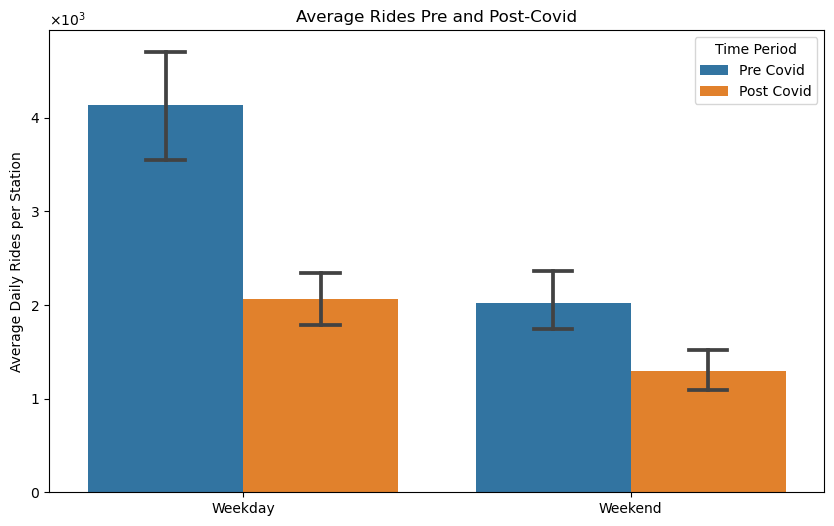

Weekday ridership at the average station is decreased 50.1 %
Pre Covid total weekday train rides per year: 4,139
Post Covid total weekday train rides per year: 2,065 

Weekend ridership at the average station is decreased 36.0 %
Pre Covid average weekend rides per station: 2,019
Post Covid average weekend rides per station: 1,291 

                        df        sum_sq       mean_sq          F  \
C(DayType)             1.0  2.991781e+08  2.991781e+08  54.253788   
C(Covid)               1.0  2.786259e+08  2.786259e+08  50.526785   
C(DayType):C(Covid)    1.0  6.432727e+07  6.432727e+07  11.665285   
Residual             564.0  3.110132e+09  5.514419e+06        NaN   

                           PR(>F)  
C(DayType)           6.287949e-13  
C(Covid)             3.569720e-12  
C(DayType):C(Covid)  6.825871e-04  
Residual                      NaN  


In [8]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create a bar plot with error bars using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='DayType', y='rides', hue='Covid', data=combined_ride_avgs_df, errorbar='ci', capsize=0.1, hue_order=['Pre Covid', 'Post Covid'])

# Configure the format of tick labels on the x and y axes
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))  # Adjust power limits as needed
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('')
plt.ylabel('Average Daily Rides per Station')
plt.title('Average Rides Pre and Post-Covid')
plt.legend(title='Time Period')

plt.show()

# Calculate average daily station ridership 
post_avg_week_rides = post_week_ride_avgs['rides'].mean()
pre_avg_week_rides = pre_week_ride_avgs['rides'].mean()

post_avg_weekend_rides = post_weekend_ride_avgs['rides'].mean()
pre_avg_weekend_rides = pre_weekend_ride_avgs['rides'].mean()

print('Weekday ridership at the average station is decreased', round(100*(pre_avg_week_rides - post_avg_week_rides)/pre_avg_week_rides, 1), '%')
print('Pre Covid total weekday train rides per year:', locale.format_string("%d", pre_avg_week_rides, grouping=True))
print('Post Covid total weekday train rides per year:', locale.format_string("%d", post_avg_week_rides, grouping=True), '\n')

print('Weekend ridership at the average station is decreased', round(100* (pre_avg_weekend_rides - post_avg_weekend_rides)/pre_avg_weekend_rides, 1), '%')
print('Pre Covid average weekend rides per station:', locale.format_string("%d", pre_avg_weekend_rides, grouping=True))
print('Post Covid average weekend rides per station:', locale.format_string("%d", post_avg_weekend_rides, grouping=True), '\n')



# Performing two-way ANOVA
model = ols('rides ~ C(DayType) + C(Covid) +\
C(DayType):C(Covid)',
            data=combined_ride_avgs_df).fit()
result = sm.stats.anova_lm(model, type=2)

# Print the result
print(result)

# Predicting when ridership might recover
The weekday ridership differences after COVID-19 are dramatic- will ridership ever recover? I will fit a ARIMA (AutoRegressive Integrated Moving Average) model to the data to predict the next 3 years of ridership. To do this I will:
1. Test for stationarity using the Augmented Dickey-Fuller (ADF) test.
2. Apply Seasonal and Trend decomposition using Loess (STL) to separate out seasonality information, the trend component, and the residual data.
3. Use ARIMA to make a prediction of the residual component
4. Fit a curve to the trend component to make an estimated prediction of the trend
5. Add back the seasonal information, the predicted trend, and the predicted residual to make a final prediction


ADF Statistic: -1.6416208056833141
p-value: 0.4614140006726884
Critical Values:
   1%: -3.471633386932248
   5%: -2.8796651107461972
   10%: -2.576433647235832


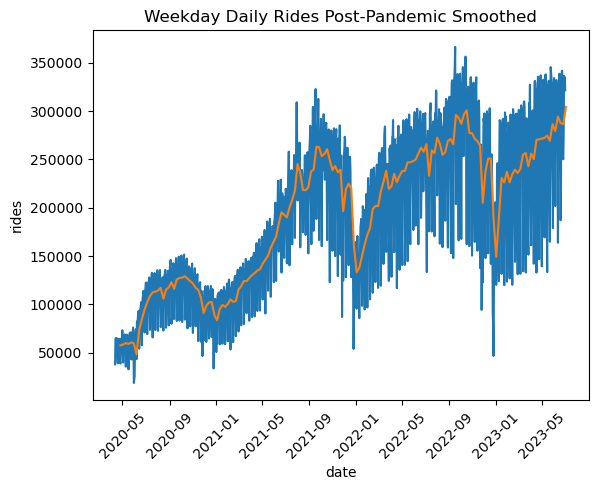

In [79]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.stattools import adfuller

# Separate ridership data by week and by weekend
weekday_ridership_df = ridership_df[ridership_df['daytype'] == 'W']
weekend_ridership_df = ridership_df[ridership_df['daytype'].isin(['U', 'A'])]
weekday_sums = weekday_ridership_df.groupby(['date'])['rides'].sum().to_frame().reset_index()
weekend_sums = weekend_ridership_df.groupby(['date'])['rides'].sum().to_frame().reset_index()
all_sums = ridership_df.groupby(['date'])['rides'].sum().to_frame().reset_index()

# Separate the data post COVID19 pandemic declaration
post_sums = all_sums[all_sums['date'] > '2020-04-11']
post_weekday_sums = weekday_sums[weekday_sums['date'] > '2020-04-11']
post_weekend_sums = weekend_sums[weekend_sums['date'] > '2020-04-11']

# Perform smoothing and weekly resampling
window = 5
testing = pd.DataFrame(weekday_sums)['rides'].ewm(span=window, adjust=True).mean()
testing.index = weekday_sums['date']
testing = testing.iloc[1:]
weekday_w_avg = testing.resample('W').mean()
weekday_w_avg = weekday_w_avg.iloc[1:]
weekday_w_avg.freq = 'W'

# do weekly averaging for weekdays
testing = pd.DataFrame(post_weekday_sums)['rides'].ewm(span=window, adjust=True).mean()
testing.index = post_weekday_sums['date']
testing = testing.iloc[1:]
p_weekday_w_avg = testing.resample('W').mean()
p_weekday_w_avg = p_weekday_w_avg.iloc[1:]
p_weekday_w_avg.freq = 'W'

# do weekly averaging for all days
testing = pd.DataFrame(post_sums)['rides'].ewm(span=window, adjust=True).mean()
testing.index = post_sums['date']
testing = testing.iloc[1:]
p_all_w_avg = testing.resample('W').mean()
p_all_w_avg = p_all_w_avg.iloc[1:]
p_all_w_avg.freq = 'W'

# do weekly averaging for all days pre and post pandemic
testing = pd.DataFrame(all_sums)['rides'].ewm(span=window, adjust=True).mean()
testing.index = all_sums['date']
testing = testing.iloc[1:]
all_w_avg = testing.resample('W').mean()
all_w_avg = all_w_avg.iloc[1:]
all_w_avg.freq = 'W'

# plot weekday post pandemic sums
sns.lineplot(data=post_sums, x='date', y='rides')
plt.title('Weekday Daily Rides Post-Pandemic')
plt.xticks(rotation=45)

# try a weighted moving avg, then plot
window = 5
fig = sns.lineplot(p_all_w_avg)
plt.title('Weekday Daily Rides Post-Pandemic Smoothed')
plt.xticks(rotation=45)

# Perform the Augmented Dickey-Fuller test
result = adfuller(p_all_w_avg)

# Extract and print the test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

#### 1. Testing for stationarity
My ADF test (and the line plot) show that this data is certainly not stationary. 

#### 2. Apply STL to separate out seasonality information, the trend component, and the residual data.
To change this so that I can run an ARIMA, I'll use STL to separate a seasonal component and a trend component from the data, then run an ARIMA on the residual. Then, I can run a separate model to predict the future trend, and then add that, the seasonal information, and the ARIMA prediction together to get a final prediction on when ridership will recover.

c:\Users\sarge\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



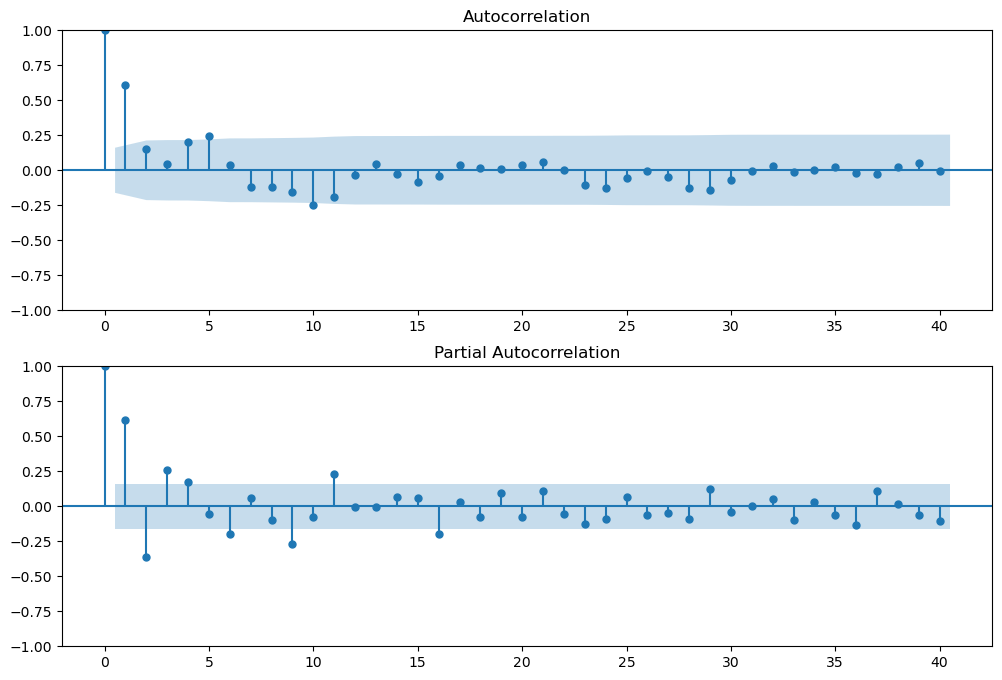

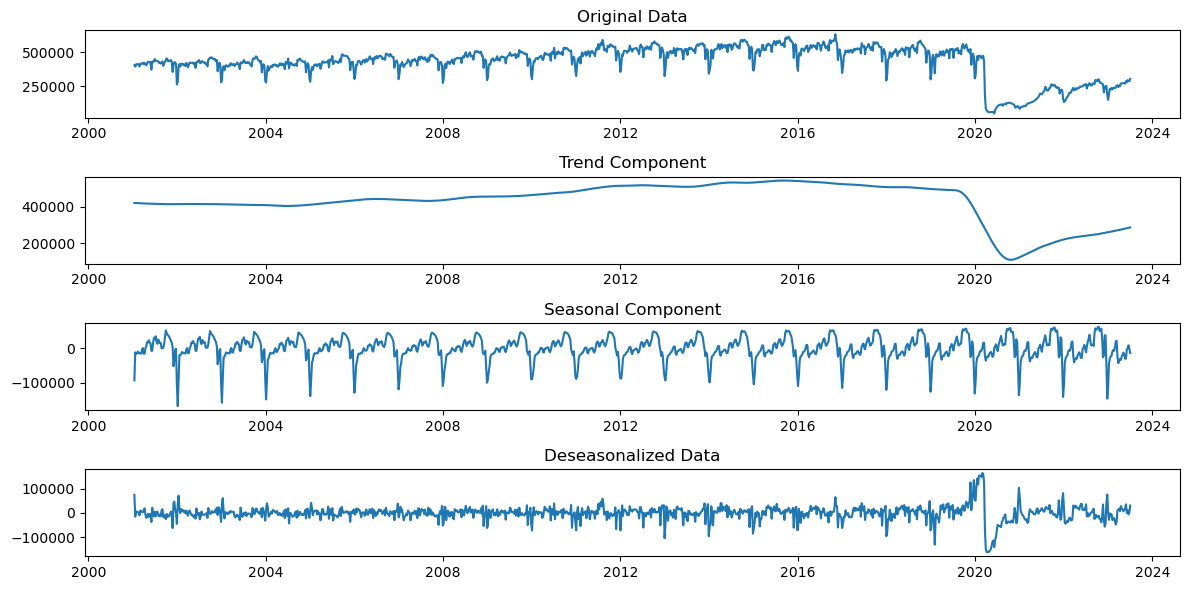

In [84]:
### Use STL to separate data into seasonal, trend, and residual components, then make residual prediction with ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta

ts = all_w_avg
ts_log = np.log(all_w_avg)
frequency = 'W'
ts.index.freq=frequency
ts_log.index.freq=frequency

# periods to forecast
seasonal = 53 # for weeks
years = 5
periods = seasonal*years # weekly data, 52 = 1 year

# Sample data with seasonality
time_series = ts
time_series.index.freq=frequency

# Perform seasonal decomposition (STL)
stl = STL(time_series, seasonal=seasonal)  # Seasonal period of 13 for monthly data
result = stl.fit()

# Deseasonalized data
deseasonalized_data = result.resid
deseasonalized_data = pd.DataFrame(deseasonalized_data).reset_index()
deseasonalized_data.set_index(deseasonalized_data['date']).asfreq(frequency)

#deseasonalized_data.set_index('date')
deseasonalized_data = deseasonalized_data.set_index('date')['resid']
deseasonalized_data.index.freq=frequency

# use only post covid data for the ARIMA model
start_date = '2020-08-31'
post_covid_residual = deseasonalized_data[deseasonalized_data.index > start_date]

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(post_covid_residual, lags=40, ax=ax1)  # Adjust the number of lags as needed
plot_pacf(post_covid_residual, lags=40, ax=ax2)  # Adjust the number of lags as needed
plt.show()

# Plot original data, seasonal component, and deseasonalized data
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(time_series)
plt.title('Original Data')
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend Component')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(deseasonalized_data)
plt.title('Deseasonalized Data')
plt.tight_layout()
plt.show()

#### 3. Run the ARIMA
Running the ARIMA yields the below prediction. I will next fit a curve to the trend component of the STL for the final piece to my prediction.

c:\Users\sarge\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  148
Model:             ARIMA(3, 1, 3)x(1, 0, [1], 52)   Log Likelihood               -1638.567
Date:                            Fri, 22 Sep 2023   AIC                           3295.135
Time:                                    13:10:54   BIC                           3322.049
Sample:                                         0   HQIC                          3306.070
                                            - 148                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7373      0.302      2.442      0.015       0.146       1.329
ar.L2         -0.8931      0.273   

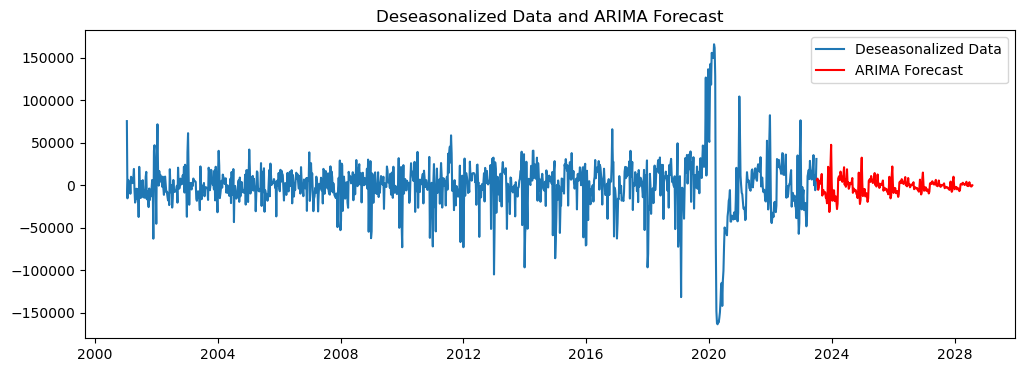

In [85]:
################# Test parameters to find optimal for ARIMA
#p_values = list(range(0,4))
#d_values = [0, 1]
#q_values = list(range(0,4))
#s_values = [52]
#best_aic = 1000000
#best_order = (3,0, 2)
#for p, d, q, s in itertools.product(p_values, d_values, q_values, s_values):
#    try:
#        model = ARIMA(post_covid_residual.values, order=(p, d, q), seasonal_order=(0, 0, 0, s))
#        results = model.fit()
#        aic = results.aic
#        if aic < best_aic:
#            best_aic = aic
#            best_order = (p, d, q, s)
#    except:
#        continue
#print("Best AIC:", best_aic)
#print("Best Order:", best_order)

# Tried a variety of parameters, these worked best
model = ARIMA(post_covid_residual.values, order=(3,1,3), seasonal_order=(1, 0, 1, 52))
model_fit = model.fit()

# Calculate the new end date
start_date = post_covid_residual.index[-1] + timedelta(weeks=1)
end_date = start_date + timedelta(weeks=periods - 1)

# Generate a new datetime index with the desired number of days added
new_date_rng = pd.date_range(start=start_date, end=end_date, freq='W')

# Print ARIMA model summary
print(model_fit.summary())

# Forecast using the ARIMA model (add back the seasonal component if needed)
forecast = model_fit.forecast(steps=periods)  # Example forecast for the next 30 periods
# Plot the forecast
plt.figure(figsize=(12, 4))
plt.plot(deseasonalized_data, label='Deseasonalized Data')
plt.plot(new_date_rng, forecast, color='red', label='ARIMA Forecast')
plt.legend()
plt.title('Deseasonalized Data and ARIMA Forecast')
plt.show()

#### 4. Fit a curve to the trend component to make an estimated prediction of the trend
This part is tricky, since we are only 3 years out from the pandemic declaration. The trend line separated by the STL is not linear. After testing many different models, I chose a combined model with a logorithmic component to capture the positive curve and eventual plateau that one can reasonably anticipate, considering historical data. This approach is not perfect, and is only an estimate, but I believe it should provide a reasonable estimation of the recovery trend, given the data from the last 3 years.

[   3.49447826 3268.79733938   14.61189724]


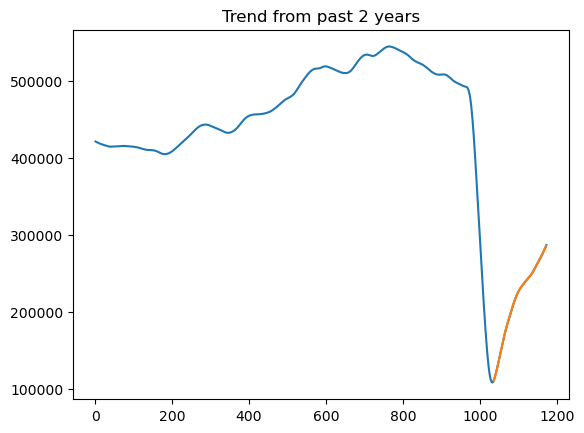

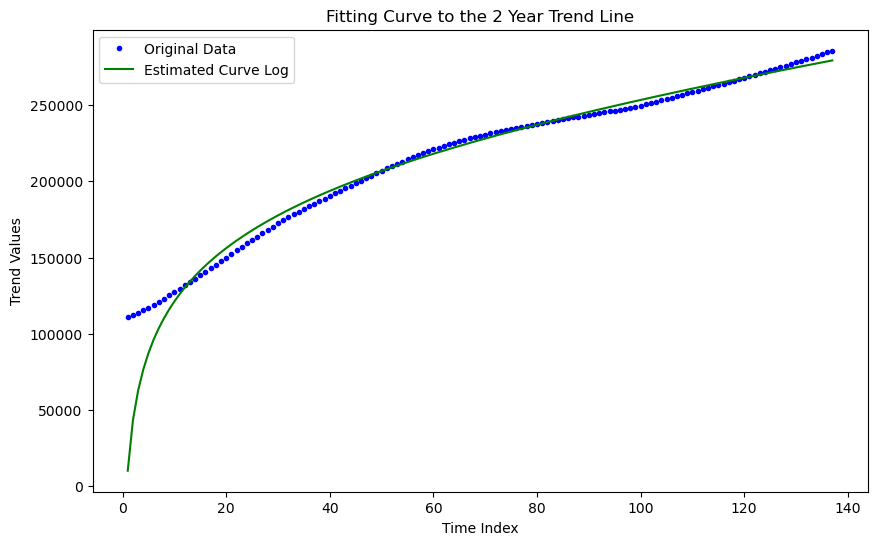

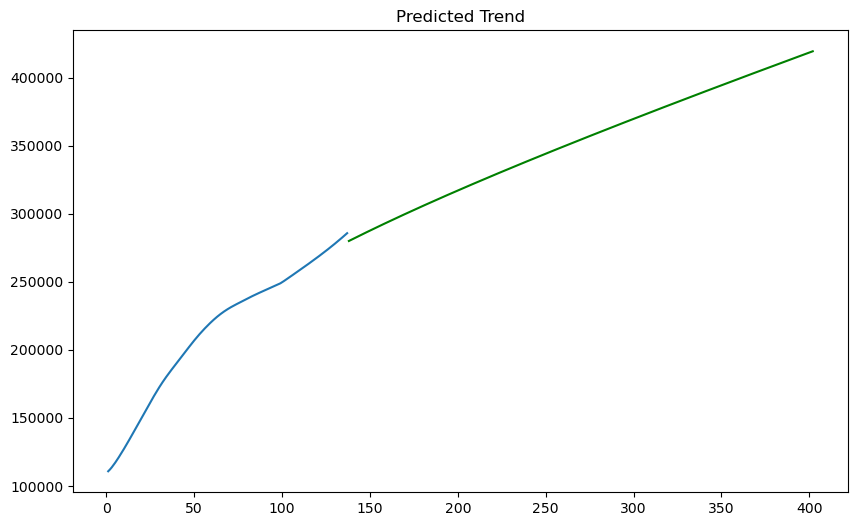

In [86]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
import numpy as np
from scipy.optimize import curve_fit

# Make a prediction using the trend component from STL decomposition
trend = result.trend.values

# make an array of x values for fitting a function
time_indices = np.array(range(1, len(trend) + 1))

plt.plot(time_indices, trend)
plt.title('Trend component from STL')
plt.title('Whole trend line')

# Cut the trend at its inflection point (2022) for modeling purposes
to_cut = 1035
from_end = 1
trend = trend[to_cut:-from_end]
X = time_indices[to_cut:-from_end] - time_indices[to_cut] + 1 # divide by 100

plt.plot(X + to_cut, trend)
plt.title('Trend from past 2 years')

#### use curve-fit to make a logorithmic-like model #################
# Define a custom logarithmic-like function
def log_curve(x, a, b, c):
    try:
        # tried a variety of models, ultimately went with a combined model to add an element of decay but keep 
        # that positive trend to be as faithful to the current trend as possible
        return (a * x + b) * (c * np.log(x)) + 10000
        #return a * np.log(abs(b * x)) + c
        #return a * x + b * x**2 + c
    except Exception as e:
        print(f"Error encountered: {e}")
        print(f"Invalid value in x: {x}")
        raise

# Fit the custom function to the data to estimate parameters
try:
    params, _ = curve_fit(log_curve, X.flatten(), trend)
except Exception as e:
    print(f"Curve fitting error: {e}")
    raise

# Extract the estimated parameters
a, b, c = params
print(params)
#################### Make predictions ###############################

# Generate time indices for the next year
next_year_time_indices = np.array(range(int(X[-1] + from_end), int(X[-1] + from_end) + len(forecast))).reshape(-1, 1)

# Predict the trend values for the next year using the custom function
next_year_trend_predictions_lg = log_curve(next_year_time_indices, a, b, c)

# Estimate the original curve used for fitting
estimated_curve_lg = log_curve(X, a, b, c)

# Plot the original data and the estimated curve
plt.figure(figsize=(10, 6))
plt.plot(X, trend, 'b.', label='Original Data')
plt.plot(X, estimated_curve_lg, 'g-', label='Estimated Curve Log')
plt.title('Fitting Curve to the 2 Year Trend Line')
plt.xlabel('Time Index')
plt.ylabel('Trend Values')
plt.legend()
plt.show()

### plot predictions
plt.figure(figsize=(10, 6))
plt.plot(X, trend, label='Original trend')
plt.plot(next_year_time_indices.flatten(), next_year_trend_predictions_lg, 'g-', label='Estimated Curve Log')
plt.title('Predicted Trend')
plt.show()


# Make a prediction about weekday ridership
All that's left to do is to recombine our components and make a final prediction. To do this, I recombine the seasonal component that I separated out using STL, plus the trend prediction I made using the STL trend, and the ARIMA prediction made using the de-seasonalized STL residual.

My model predicts ridership recovery to continue its slow increase over the next 5 years, not quite recovering to prepandemic levels. Of course, I built the model using limited data, and it's possible people's behavior will plateau before full recovery, or ridership may recover sooner. With the rise of remote work, it's possible it will take much longer for ridership to recover to pre-pandemic levels. 

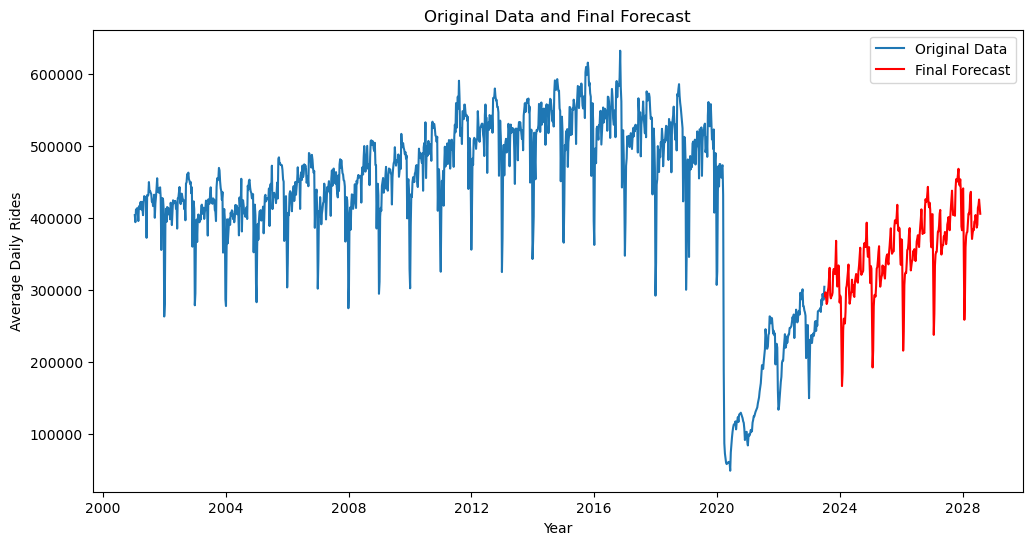

In [87]:
# Combine the ARIMA forecast with the seasonal component and the trend prediction
decomp_forecast = forecast.reshape(periods, 1)
seasonal_comp = result.seasonal[-periods:].values.reshape(periods, 1)
trend_comp = next_year_trend_predictions_lg
reconstructed_forecast = np.add(np.add(decomp_forecast, seasonal_comp), trend_comp)

# Plot the original data and the final forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original Data')
plt.plot(new_date_rng, reconstructed_forecast, label='Final Forecast', color='red')
plt.legend()
plt.title('Original Data and Final Forecast')
plt.ylabel('Average Daily Rides')
plt.xlabel('Year')
plt.show()